In [ ]:
# imports
# !pip install torch torch-geometric scikit-learn



In [ ]:
import pandas as pd
import numpy as np
import networkx as nx

# patient simmilatiry

Step-by-Step GNN Project Plan
We'll implement a pipeline like this:

Generate synthetic patient data inspired by MIMIC-III.

Create a patient similarity graph using NetworkX (based on shared features).

Convert to PyTorch Geometric data format.

Implement a GNN (e.g., GCN or GraphSAGE).

Train the GNN to embed patients.

Use the embeddings to measure patient similarity.

#Step 1: Generate Synthetic Patient Data
Let's generate a dataset that mimics key fields from MIMIC-III:

In [99]:


# Reproducibility
np.random.seed(42)

# this is at random

def generate_synthetic_mimic_data(num_patients=100):
    data = pd.DataFrame({
        'patient_id': np.arange(1, num_patients + 1),
        'age': np.random.randint(18, 90, size=num_patients),
        'gender': np.random.choice(['M', 'F'], size=num_patients),
        'has_diabetes': np.random.choice([0, 1], size=num_patients),
        'has_hypertension': np.random.choice([0, 1], size=num_patients),
        'diagnosis': np.random.choice(['heart failure', 'sepsis', 'pneumonia', 'stroke'], size=num_patients),
        'procedure': np.random.choice(['CABG', 'ventilation', 'dialysis', 'CT scan'], size=num_patients),
        'num_lab_tests': np.random.randint(3, 15, size=num_patients),
        'length_of_stay': np.random.normal(7, 3, size=num_patients).clip(1, 20)
    })
    return data

# now we have a probability distribution

# def generate_synthetic_mimic_data(num_patients=100):
#     data = pd.DataFrame({
#         'patient_id': np.arange(1, num_patients + 1),
#         'age': np.random.randint(18, 90, size=num_patients),
#         'gender': np.random.choice(['M', 'F'], size=num_patients, p=[0.55, 0.45]),  # More males
#         'has_diabetes': np.random.choice([0, 1], size=num_patients, p=[0.7, 0.3]),  # 30% with diabetes
#         'has_hypertension': np.random.choice([0, 1], size=num_patients, p=[0.6, 0.4]),  # 40% with hypertension
#         'diagnosis': np.random.choice(
#             ['heart failure', 'sepsis', 'pneumonia', 'stroke'],
#             size=num_patients,
#             p=[0.30, 0.49, 0.20, 0.01]  # Higher chance for sepsis
#         ),
#         'procedure': np.random.choice(
#             ['CABG', 'ventilation', 'dialysis', 'CT scan'],
#             size=num_patients,
#             p=[0.1, 0.3, 0.2, 0.4]  # CT scan most common
#         ),
#         'num_lab_tests': np.random.randint(3, 15, size=num_patients),
#         'length_of_stay': np.random.normal(7, 3, size=num_patients).clip(1, 20)
#     })

#     return data


# Generate and preview
synthetic_data = generate_synthetic_mimic_data(100)
print(synthetic_data.head())


   patient_id  age gender  has_diabetes  has_hypertension      diagnosis  \
0           1   69      F             0                 0      pneumonia   
1           2   32      F             1                 1         stroke   
2           3   89      M             0                 1  heart failure   
3           4   78      M             1                 0         stroke   
4           5   38      M             0                 1  heart failure   

     procedure  num_lab_tests  length_of_stay  
0     dialysis              6        6.022081  
1  ventilation              7       16.761955  
2         CABG             14        2.365003  
3  ventilation             12        4.471795  
4  ventilation             12        8.176126  


In [100]:
synthetic_data.head(2)

,patient_id,age,gender,has_diabetes,has_hypertension,diagnosis,procedure,num_lab_tests,length_of_stay
0,1,69,F,0,0,pneumonia,dialysis,6,6.022081
1,2,32,F,1,1,stroke,ventilation,7,16.761955


# Step 2: Create the Patient Similarity Graph

We'll define edges between patients based on shared characteristics such as:

Same diagnosis

Age difference within 5 years

Same procedure

Or both having a specific comorbidity (e.g., diabetes)

We'll use NetworkX to build an undirected graph where:

Nodes are patients

Edges represent some form of clinical similarity

In [140]:
import networkx as nx

def build_similarity_graph(data):
    G = nx.Graph()

    # Add all patients as nodes with attributes
    for _, row in data.iterrows():
        G.add_node(row['patient_id'], **row.to_dict())

    # # Define similarity rules
    # def are_similar(p1, p2):
    #     return (
    #         abs(p1['age'] - p2['age']) <= 1 or
    #         p1['diagnosis'] == p2['diagnosis'] or
    #         p1['procedure'] == p2['procedure'] or
    #         (p1['has_diabetes'] == 1 and p2['has_diabetes'] == 1)
    #     )
    # Define similarity rules
    def are_similar(p1, p2):
        return (
            abs(p1['age'] - p2['age']) <= 1 or
            # p1['gender'] == p2['gender'] and
            p1['diagnosis'] == p2['diagnosis'] and
            p1['procedure'] == p2['procedure'] #and
            # (p1['has_diabetes'] == 1 and p2['has_diabetes'] == 1)
        )

    # Add edges based on similarity
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            p1 = data.iloc[i]
            p2 = data.iloc[j]

            if are_similar(p1, p2):
                G.add_edge(p1['patient_id'], p2['patient_id'])

    return G

# Build graph
patient_graph = build_similarity_graph(synthetic_data)

# Show basic info
print(f"Number of patients (nodes): {patient_graph.number_of_nodes()}")
print(f"Number of similarity edges: {patient_graph.number_of_edges()}")

# Optionally visualize (in small cases)
# nx.draw(patient_graph, with_labels=True)


Number of patients (nodes): 100
Number of similarity edges: 496


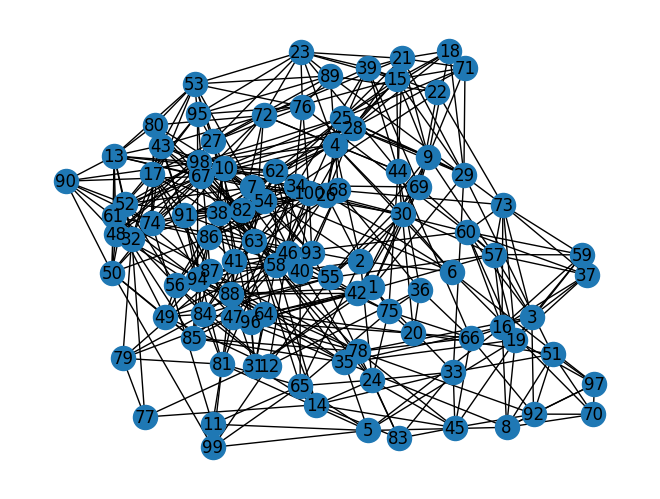

In [141]:
# Optionally visualize (in small cases)
nx.draw(patient_graph, with_labels=True)

# Step 3: Convert to PyTorch Geometric Data Object
We'll:

Encode categorical features (gender, diagnosis, procedure)

Extract a feature matrix x for each node

Build an edge index tensor from the NetworkX graph

In [67]:
!pip install torch torch-geometric scikit-learn


In [142]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
import networkx as nx

def convert_to_pyg_data(graph: nx.Graph):
    # Extract node data
    df = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'patient_id'}, inplace=True)

    # Encode categorical features
    encoders = {
        'gender': LabelEncoder(),
        'diagnosis': LabelEncoder(),
        'procedure': LabelEncoder()
    }
    for col, encoder in encoders.items():
        df[col] = encoder.fit_transform(df[col])

    # Normalize numeric features
    numeric_cols = ['age', 'num_lab_tests', 'length_of_stay']
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Create feature tensor
    feature_cols = ['age', 'gender', 'has_diabetes', 'has_hypertension',
                    'diagnosis', 'procedure', 'num_lab_tests', 'length_of_stay']
    x = torch.tensor(df[feature_cols].values, dtype=torch.float)

    # Build edge index
    edge_index = torch.tensor(list(graph.edges()), dtype=torch.long).t().contiguous()

    # Create PyG data object
    data = Data(x=x, edge_index=edge_index)

    return data

# Convert NetworkX graph to PyTorch Geometric format
pyg_data = convert_to_pyg_data(patient_graph)

print(f"PyG Data object:\n{pyg_data}")
print(f"Number of nodes: {pyg_data.num_nodes}")
print(f"Number of edges: {pyg_data.num_edges}")
print(f"Feature shape: {pyg_data.x.shape}")


PyG Data object:
Data(x=[100, 8], edge_index=[2, 496])
Number of nodes: 100
Number of edges: 496
Feature shape: torch.Size([100, 8])


In [85]:
# num_nodes = pyg_data.x.size(0)  # Should be 100
# valid_mask = (pyg_data.edge_index < num_nodes).all(dim=0)
# pyg_data.edge_index = pyg_data.edge_index[:, valid_mask]

In [143]:
# Step 1: Get number of nodes
num_nodes = pyg_data.x.size(0)  # Should be 100
print(f"[INFO] Number of nodes: {num_nodes}")

# Step 2: Check how many invalid edges exist
invalid_mask = (pyg_data.edge_index >= num_nodes).any(dim=0)
num_invalid = invalid_mask.sum().item()
print(f"[INFO] Number of invalid edges (with index >= {num_nodes}): {num_invalid}")

# Optional: Show a few bad edges
if num_invalid > 0:
    print("[DEBUG] Sample invalid edges:")
    print(pyg_data.edge_index[:, invalid_mask][:, :5])  # Print first 5 invalid ones

# Step 3: Create valid mask and apply it
valid_mask = (pyg_data.edge_index < num_nodes).all(dim=0)
pyg_data.edge_index = pyg_data.edge_index[:, valid_mask]
print(f"[INFO] edge_index shape after filtering: {pyg_data.edge_index.shape}")


[INFO] Number of nodes: 100
[INFO] Number of invalid edges (with index >= 100): 12
[DEBUG] Sample invalid edges:
tensor([[ 10,  38,  40,  41,  46],
        [100, 100, 100, 100, 100]])
[INFO] edge_index shape after filtering: torch.Size([2, 484])


#Step 4: Define a GNN to Learn Patient Representations

We'll use a Graph Convolutional Network (GCN) from torch_geometric.nn to learn node embeddings that capture each patient’s information and relationship to others in the graph.

Since this is about patient similarity, we’ll:

Train the model using an unsupervised objective

Use the learned embeddings later to compute similarity (e.g., cosine similarity) between patients

# 1. Define a Simple GCN

In [144]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class PatientGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(PatientGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  # This will be the final embedding of each patient


This is the initializer. You're setting up the layers of your GNN:

in_channels: Number of input features per node (e.g., age, vitals, etc.)

hidden_channels: Size of the hidden layer (intermediate representation)

out_channels: Size of the output embedding vector

These are two graph convolution layers:

GCNConv is a message-passing layer that aggregates features from neighboring nodes.

The first layer takes the raw features → hidden representation.

The second layer refines that hidden representation → final embedding.

This is the forward pass. It defines how the input flows through the model.

x: Node features (tensor of shape [num_nodes, in_channels])

edge_index: Graph connectivity, shape [2, num_edges], with source/target node indices

#2. Train GNN Using Similarity Loss

We'll use cosine similarity loss between connected and unconnected node pairs:

Similar patients → higher cosine similarity

Dissimilar patients → lower similarity

Here's a basic training loop:


In [145]:
import torch
import torch.nn.functional as F

def train_similarity_model(data, embedding_dim=128, epochs=200, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PatientGNN(data.num_node_features, 32, embedding_dim).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # print(f'mika {data.x.shape} ' )

        embeddings = model(data.x, data.edge_index)  # shape [N, embedding_dim]

        # print(f'mika after {data.x.shape} ' )
        # Sample positive edges (existing ones)
        pos_edge_index = data.edge_index.t()

        # Sample negative edges (non-existent edges)
        num_pos = pos_edge_index.shape[0]
        all_nodes = torch.arange(data.num_nodes, device=device)
        rand_src = all_nodes[torch.randint(0, data.num_nodes, (num_pos,), device=device)]
        rand_dst = all_nodes[torch.randint(0, data.num_nodes, (num_pos,), device=device)]
        neg_edge_index = torch.stack([rand_src, rand_dst], dim=1)

        # Compute similarities
        pos_sim = F.cosine_similarity(embeddings[pos_edge_index[:, 0]], embeddings[pos_edge_index[:, 1]])
        neg_sim = F.cosine_similarity(embeddings[neg_edge_index[:, 0]], embeddings[neg_edge_index[:, 1]])

        # Loss: encourage higher similarity for positive edges and lower for negative
        loss = -torch.log(torch.sigmoid(pos_sim)).mean() - torch.log(1 - torch.sigmoid(neg_sim)).mean()

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return model


In [146]:
trained_model = train_similarity_model(pyg_data, embedding_dim=16)


Epoch 0, Loss: 1.5266
Epoch 10, Loss: 1.4716
Epoch 20, Loss: 1.3940
Epoch 30, Loss: 1.2973
Epoch 40, Loss: 1.2222
Epoch 50, Loss: 1.2397
Epoch 60, Loss: 1.2180
Epoch 70, Loss: 1.2075
Epoch 80, Loss: 1.2121
Epoch 90, Loss: 1.2163
Epoch 100, Loss: 1.2093
Epoch 110, Loss: 1.1864
Epoch 120, Loss: 1.1887
Epoch 130, Loss: 1.1818
Epoch 140, Loss: 1.1902
Epoch 150, Loss: 1.2002
Epoch 160, Loss: 1.1924
Epoch 170, Loss: 1.1834
Epoch 180, Loss: 1.1758
Epoch 190, Loss: 1.1865


#Step 5: Evaluate Similarity Between Patients Using the GNN.

Now that the GNN model has learned embeddings for each patient, we can:

Extract those embeddings

Compute pairwise similarity

Find similar patients (for a given patient)

Optionally, visualize clusters or neighbor relationships

#1. Extract Embeddings

In [147]:
import torch.nn.functional as F

# Put model in eval mode and move to CPU (for inference)
trained_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pyg_data = pyg_data.to(device)
with torch.no_grad():
    embeddings = trained_model(pyg_data.x, pyg_data.edge_index).cpu()  # shape [num_nodes, embedding_dim]


# 2. Compute Cosine Similarity Matrix

In [148]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Convert to numpy
embedding_matrix = embeddings.numpy()

# Cosine similarity between each pair of patients
similarity_matrix = cosine_similarity(embedding_matrix)

# Optional: create a DataFrame for better readability
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.index.name = "Patient_ID"
similarity_df.columns.name = "Similar_To"
similarity_df.round(3).head(10)  # Show top 10x10 matrix


Similar_To,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Patient_ID,,,,,,,,,,,,,,,,,,,,,
0,1.000,-0.041,-0.362,0.137,-0.445,0.660,-0.540,-0.642,0.729,0.063,...,-0.190,0.302,0.380,-0.561,0.299,0.177,-0.162,-0.134,-0.777,0.310
1,-0.041,1.000,0.113,-0.406,0.099,-0.312,0.079,0.059,-0.283,0.985,...,-0.238,-0.708,-0.618,-0.307,-0.677,0.091,0.981,-0.242,-0.275,-0.296
2,-0.362,0.113,1.000,-0.426,0.987,-0.498,0.965,0.924,-0.459,0.083,...,-0.377,-0.507,-0.631,0.108,-0.668,-0.479,0.104,-0.021,0.144,-0.448
3,0.137,-0.406,-0.426,1.000,-0.476,0.515,-0.478,-0.459,0.294,-0.397,...,0.806,0.610,0.735,-0.171,0.591,-0.051,-0.467,-0.319,0.338,0.715
4,-0.445,0.099,0.987,-0.476,1.000,-0.584,0.992,0.964,-0.542,0.059,...,-0.386,-0.502,-0.667,0.207,-0.636,-0.429,0.111,-0.005,0.208,-0.501
5,0.660,-0.312,-0.498,0.515,-0.584,1.000,-0.640,-0.700,0.953,-0.182,...,0.141,0.266,0.719,-0.541,0.365,-0.230,-0.442,0.145,-0.449,0.751
6,-0.540,0.079,0.965,-0.478,0.992,-0.640,1.000,0.989,-0.601,0.026,...,-0.334,-0.494,-0.670,0.262,-0.613,-0.385,0.108,0.039,0.304,-0.506
7,-0.642,0.059,0.924,-0.459,0.964,-0.700,0.989,1.000,-0.670,-0.011,...,-0.251,-0.466,-0.663,0.323,-0.583,-0.327,0.109,0.071,0.420,-0.513
8,0.729,-0.283,-0.459,0.294,-0.542,0.953,-0.601,-0.670,1.000,-0.157,...,-0.055,0.223,0.676,-0.517,0.297,-0.148,-0.407,0.337,-0.595,0.578


# 3. Find Most Similar Patients

In [149]:
def find_similar_patients(patient_id, top_k=5):
    sim_scores = similarity_matrix[patient_id]
    top_indices = sim_scores.argsort()[::-1][1:top_k+1]  # Skip self
    return top_indices, sim_scores[top_indices]

# Example: get top 5 most similar to patient 3
similar_ids, similarities = find_similar_patients(3)
print("Top similar patients to patient 3:")
for pid, score in zip(similar_ids, similarities):
    print(f"Patient {pid} with similarity score: {score:.3f}")


Top similar patients to patient 3:
Patient 37 with similarity score: 0.928
Patient 78 with similarity score: 0.918
Patient 59 with similarity score: 0.914
Patient 60 with similarity score: 0.831
Patient 90 with similarity score: 0.806


# 4. Visualize the Graph with Similarity-Based Colors (Optional)

In [115]:
from torch_geometric.utils import to_networkx


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

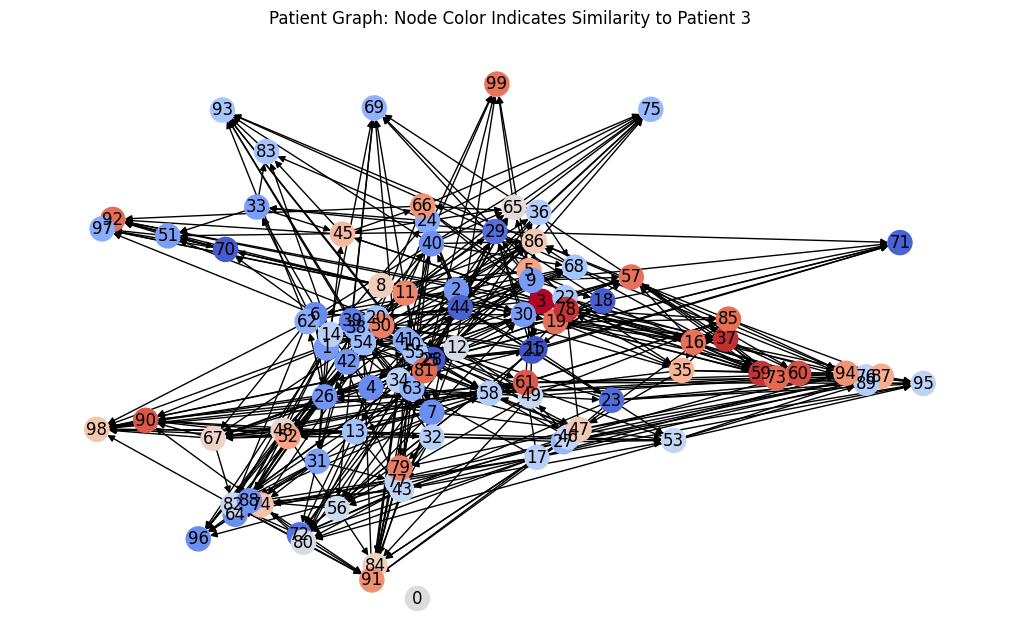

In [150]:
import matplotlib.pyplot as plt
import networkx as nx

# Convert PyG back to NetworkX for visualization
G_nx = to_networkx(pyg_data)

# Use similarity to a patient as color (e.g. to patient 3)
similarity_to_p3 = similarity_matrix[3]
colors = similarity_to_p3

plt.figure(figsize=(10, 6))
nx.draw(G_nx, node_color=colors, with_labels=True, cmap=plt.cm.coolwarm, node_size=300)
plt.title("Patient Graph: Node Color Indicates Similarity to Patient 3")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm), label="Cosine Similarity")
plt.show()


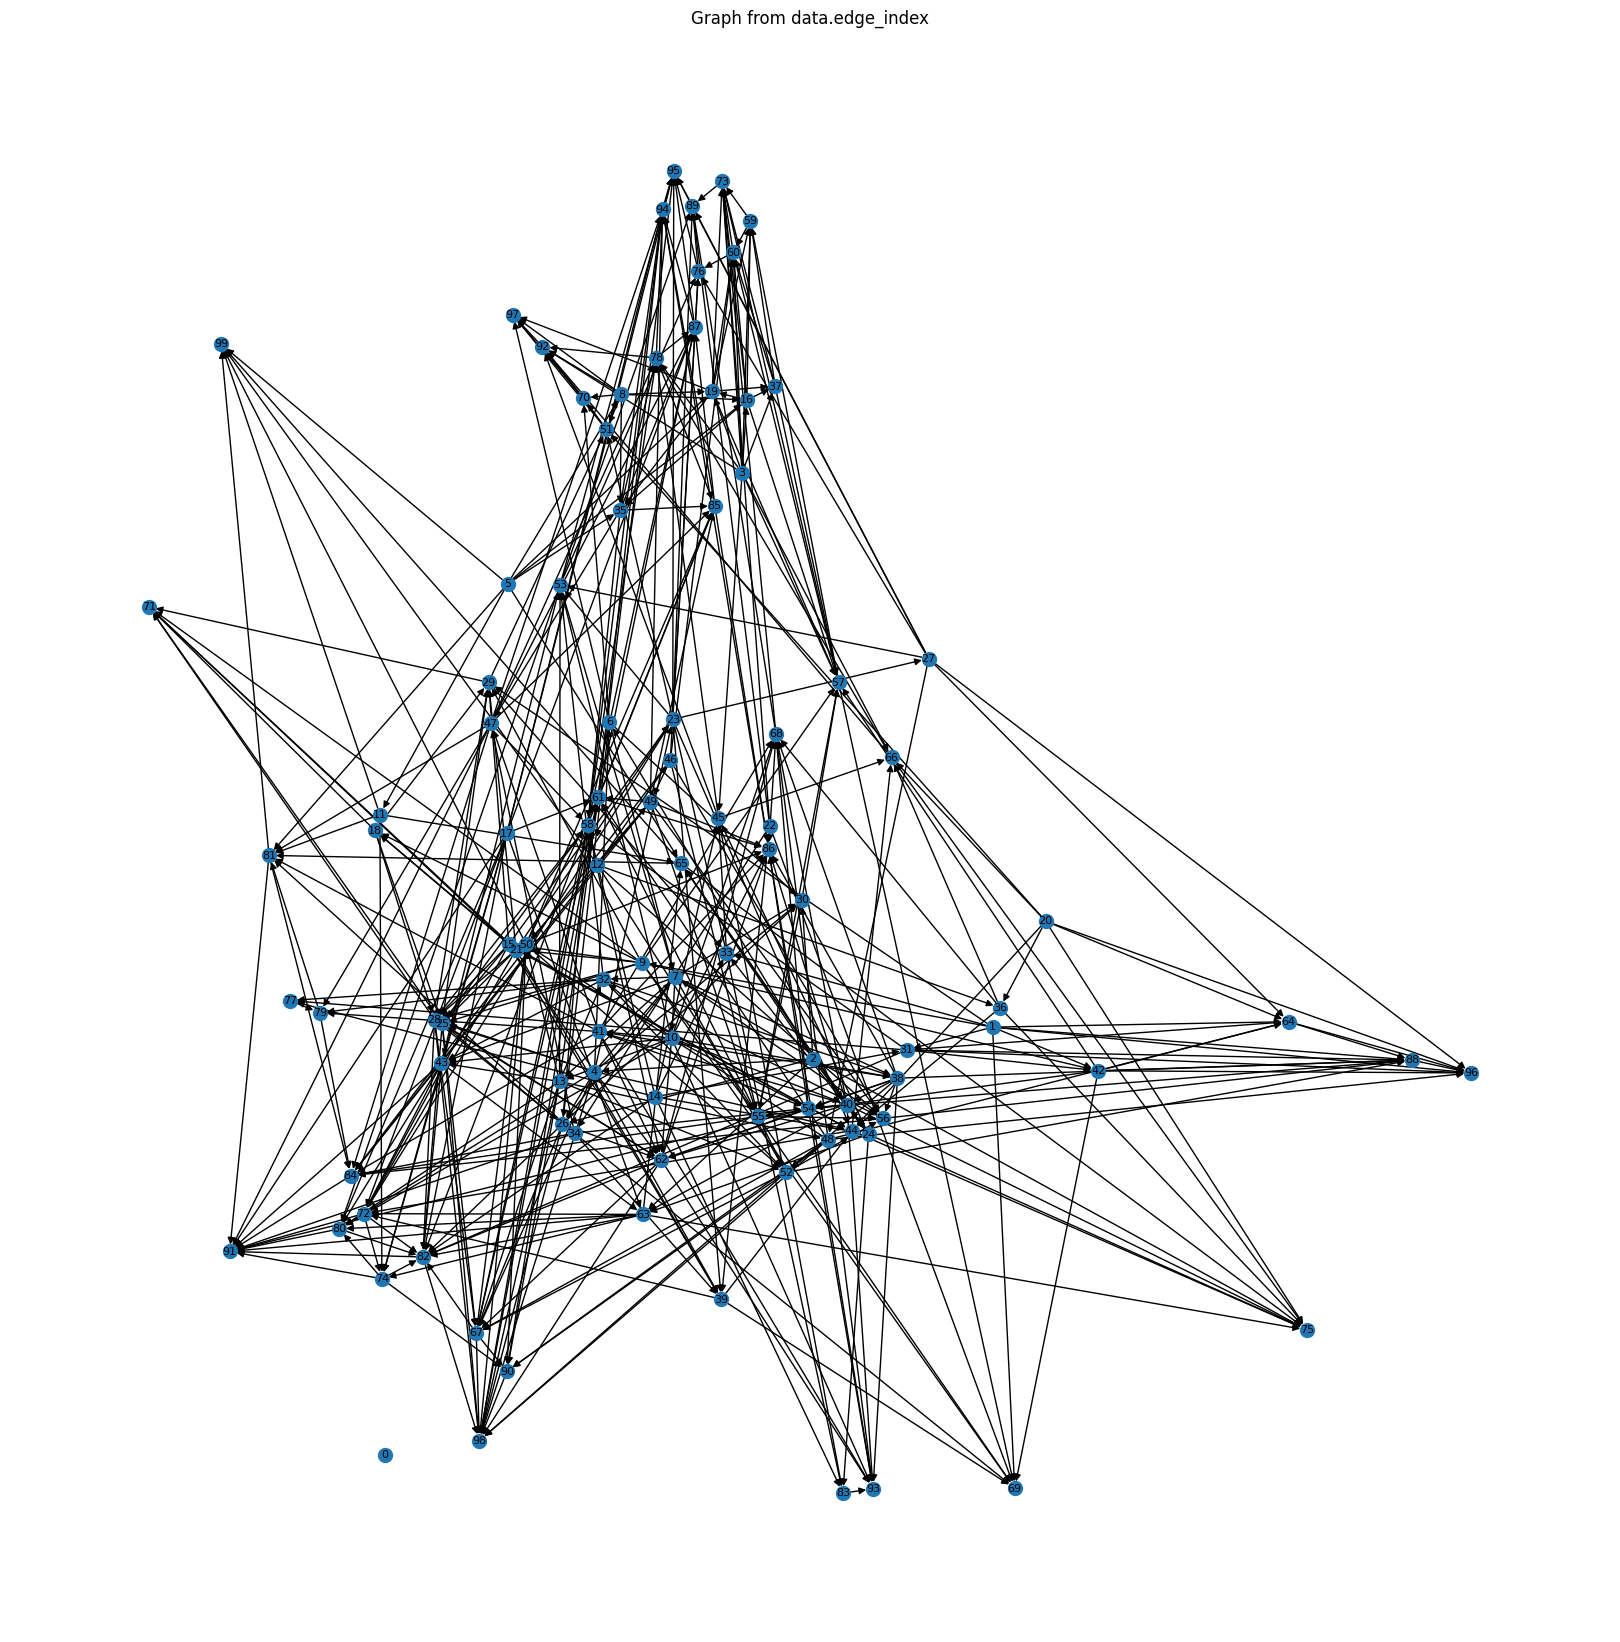

In [151]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

G = to_networkx(pyg_data)
plt.figure(figsize=(16, 16))
nx.draw(G, with_labels=True, node_size=100, font_size=8)
plt.title("Graph from data.edge_index")
plt.show()


# another plot

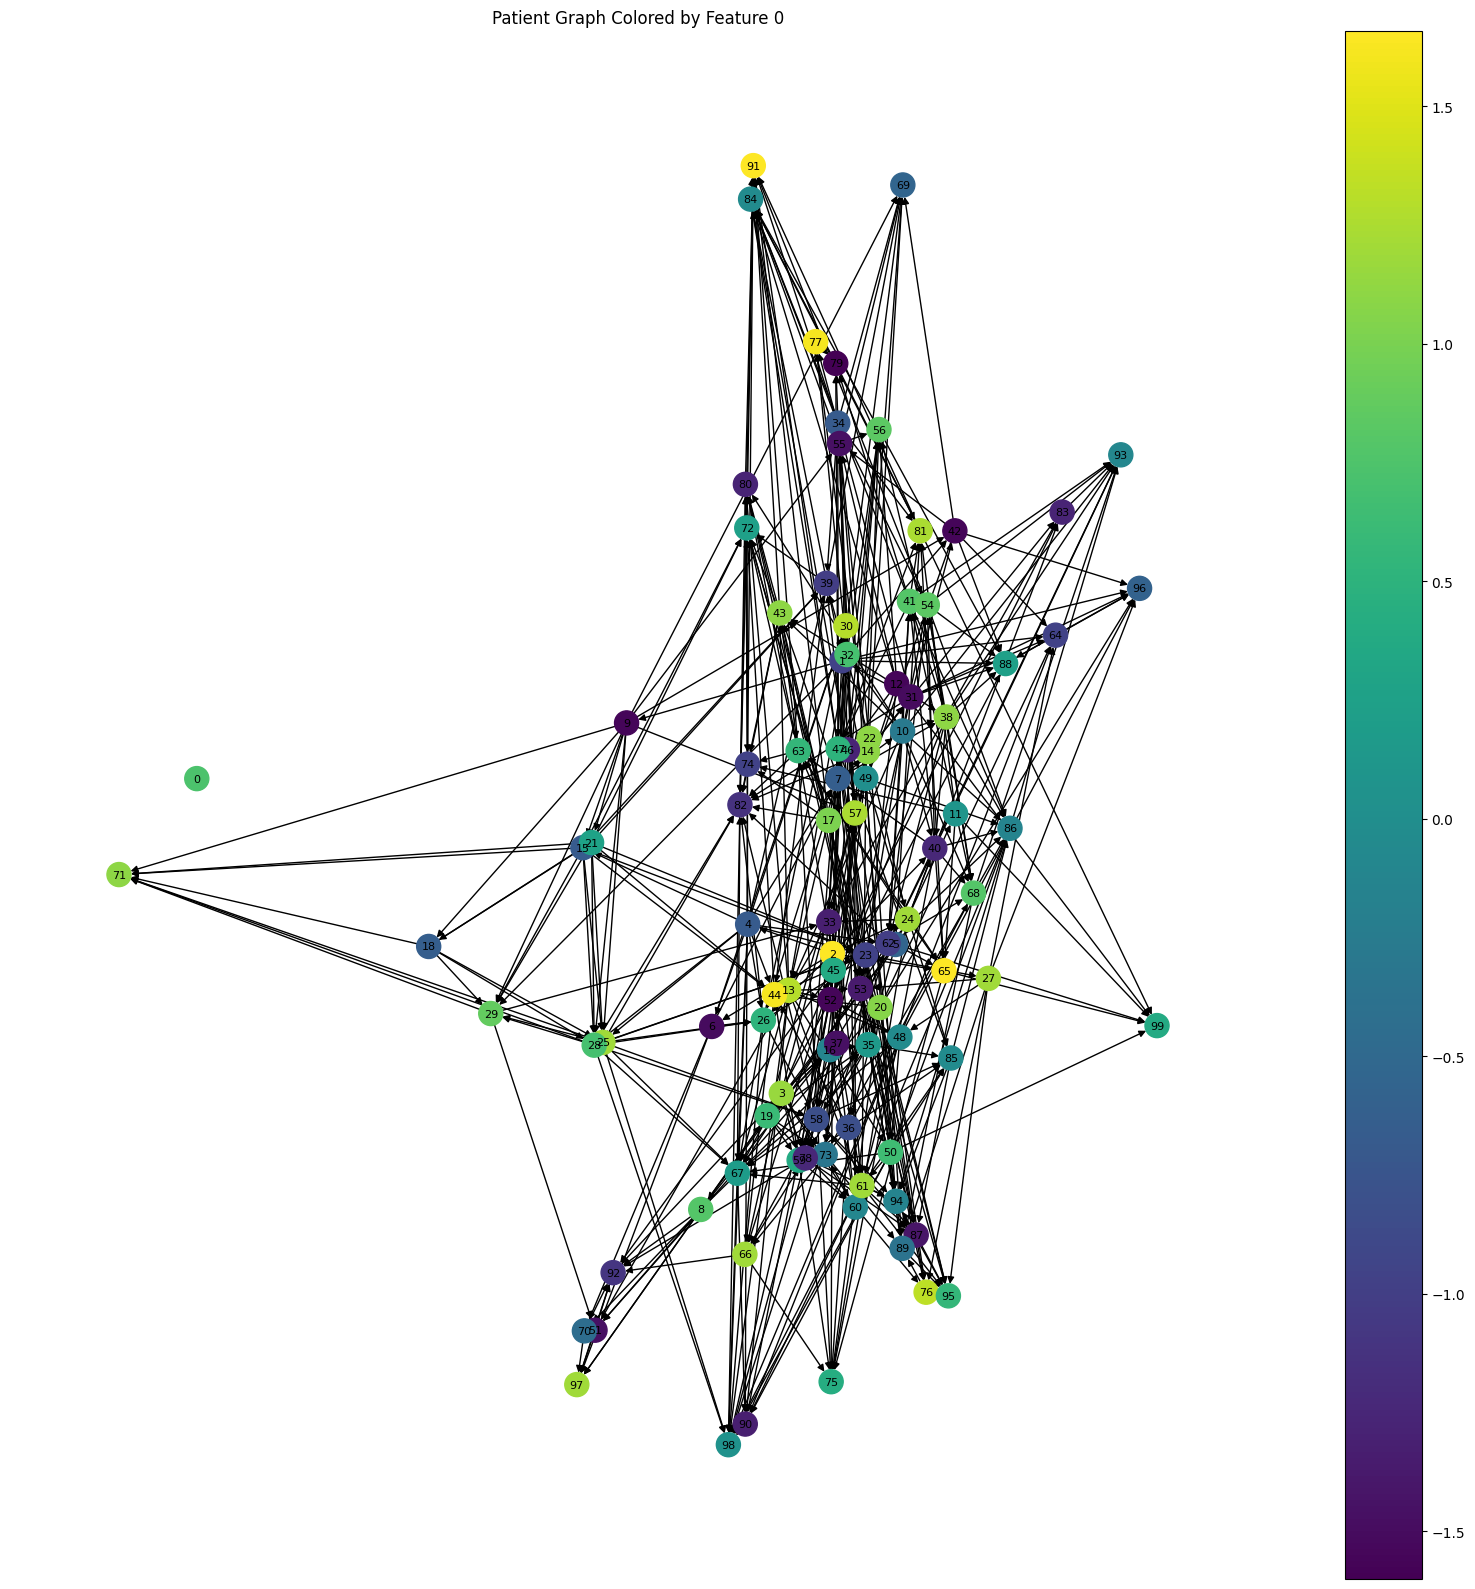

In [152]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert PyG graph to NetworkX
G = to_networkx(pyg_data)

# Optional: color nodes by feature or degree
node_color = pyg_data.x[:, 0].cpu().numpy()  # example: use first feature

# Plot
fig, ax = plt.subplots(figsize=(16, 16))
pos = nx.spring_layout(G)  # layout
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap='viridis', ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array(node_color)
plt.colorbar(sm, ax=ax)

plt.title("Patient Graph Colored by Feature 0")
plt.axis('off')
plt.tight_layout()
plt.show()
